# Poiseuille Pipe (Periodic)

The simulation of a periodic Poiseuille pipe flow is used for the validation of the immersed boundary method (IBM) as to represent a curved boundary. In the current case, the external force density term represents the pressure gradient $F_{x}=-\mathrm{d}p/\mathrm{d}x$, periodicity is considered in all boundaries, and an cylindrical Lagrangian mesh is placed with axis alligned to the $x$-axis.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/03_poiseuille_pipe_flow.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

The simulation parameters are shown below

In [2]:
from nassu.cfg.schemes.simul import SimulationConfigs
import pandas as pd

dct = {"N": [], "F": [], "tau": [], "time_steps": []}


def add_to_dict(sim_cfg: SimulationConfigs):
    dct["N"].append(sim_cfg.domain.domain_size.x)
    dct["tau"].append(sim_cfg.models.LBM.tau)
    dct["F"].append(sim_cfg.models.LBM.F.x)
    dct["time_steps"].append(sim_cfg.n_steps)


sim_cfgs_use = [
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if sim_cfg.name.startswith("periodicPoiseuillePipeN")
]
for sim_cfg in sim_cfgs_use:
    add_to_dict(sim_cfg)

df = pd.DataFrame(dct, index=None)

df

N             F  tau  time_steps
0   24  6.250000e-05  0.8        2000
1   40  7.812500e-06  0.8        8000
2   72  9.765630e-07  0.8       32000
3  136  1.220700e-07  0.8      128000

Where N represents the domain size, directly correlated to the scale of the problem and the level of mesh refinement. Also, F is a volumetric force generating the flow. Since the domain size changes between cases F must be reescaled in order to keep the velocity profile constant.

An extra spacing of 2 lattices at each side of the cylinder is kept to assure a complete interpolation-spread procedure.

Functions to use for processing of poiseuille pipe.

In [3]:
from typing import Callable
import numpy as np
from lnas import LnasFormat


def get_poiseuille_pipe_analytical_func() -> Callable:
    """Poiseuille analytical velocity function

    Returns:
        Callable[[float], float]: Analytical velocity function
    """
    return lambda r: 2 * (1 - r * r)


def get_poiseuille_pipe_numerical_avg_vel(ux_vals: np.ndarray) -> float:
    # Average velocity is ~half the maximun velocity.
    # Numerical integration gives worse results for average velocity
    return np.max(ux_vals) / 2


def get_pos_values_inside_pipe(sim_cfg: SimulationConfigs) -> np.ndarray:
    lnas_filename = sim_cfg.output.bodies["cylinder"].lnas_transformed
    lnas = LnasFormat.from_file(lnas_filename)
    vertices = lnas.geometry.vertices

    x_val = sim_cfg.domain.domain_size.x / 2
    z_val = sim_cfg.domain.domain_size.z / 2
    min_y, max_y = (vertices[:, 1].min(), vertices[:, 1].max())
    min_y, max_y = int(np.ceil(min_y)), int(np.ceil(max_y))

    p1, p2 = (x_val, min_y, z_val), (x_val, max_y, z_val)
    line = np.linspace(p1, p2, num=max_y - min_y, endpoint=False)
    return line


def plot_analytical_poiseuille_pipe_vels(ax):
    x = np.arange(
        -1,
        1.01,
        0.01,
    )
    analytical_func = get_poiseuille_pipe_analytical_func()
    analytical_data = analytical_func(x)
    ax.plot(x, analytical_data, "--k", label="Analytical")

## Results



Extract the velocity profile from simulation

In [4]:
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
from tests.validation.notebooks import common

extracted_data = {}
array_to_extract = "ux"

for sim_cfg in sim_cfgs_use:
    export_instantaneous_cfg = sim_cfg.output.instantaneous
    macr_export = export_instantaneous_cfg["default"]
    time_step = macr_export.time_steps(sim_cfg.n_steps)[-1]
    reader = macr_export.read_vtm_export(time_step)

    pos = get_pos_values_inside_pipe(sim_cfg)
    # Sum 0.5 because data is cell data, so it's in the center of the cell
    p1 = pos[0] + 0.5
    p2 = pos[-1] + 0.5

    line = common.create_line(p1, p2, len(pos) - 1)

    # Get the points from the vtkLineSource
    polyData = line.GetOutput()
    points = polyData.GetPoints()

    probe_filter = common.probe_over_line(line, reader.GetOutput())

    probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(array_to_extract))
    extracted_data[(sim_cfg.sim_id, sim_cfg.name)] = {"pos": pos, "data": probed_data}

extracted_data.keys()

dict_keys([(0, 'periodicPoiseuillePipeN16'), (0, 'periodicPoiseuillePipeN32'), (0, 'periodicPoiseuillePipeN64'), (0, 'periodicPoiseuillePipeN128')])

The velocity profile at the end of simulation is compared with the steady state analytical solution below:

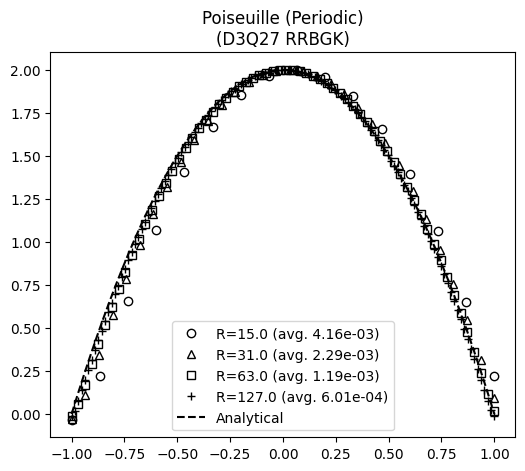

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

style_num = ["o", "^", "s", "+", "x"]


def normalize_pos(pos):
    # Normalize between -1 and 1
    pos -= pos.min()
    R = pos.max()
    pos /= pos.max()
    pos -= 0.5
    pos *= 2

    return R


for sim_cfg, mkr_style in zip(sim_cfgs_use, style_num):
    num_data = extracted_data[(sim_cfg.sim_id, sim_cfg.name)]
    num_avg_vel = get_poiseuille_pipe_numerical_avg_vel(num_data["data"])
    pos_norm = num_data["pos"][:, 1].copy()
    R = normalize_pos(pos_norm)

    ax.plot(
        pos_norm,
        num_data["data"] / num_avg_vel,
        mkr_style,
        label=f"R={R} (avg. {num_avg_vel:.2e})",
        fillstyle="none",
        c="k",
    )

sim_cfg_ref = sim_cfgs_use[0]
plot_analytical_poiseuille_pipe_vels(ax)
ax.set_title(
    f"Poiseuille (Periodic)\n({sim_cfg_ref.models.LBM.vel_set} {sim_cfg_ref.models.LBM.coll_oper})"
)
ax.legend()
plt.show(fig)

The first order error decay under grid refinement for the present case is also verified:


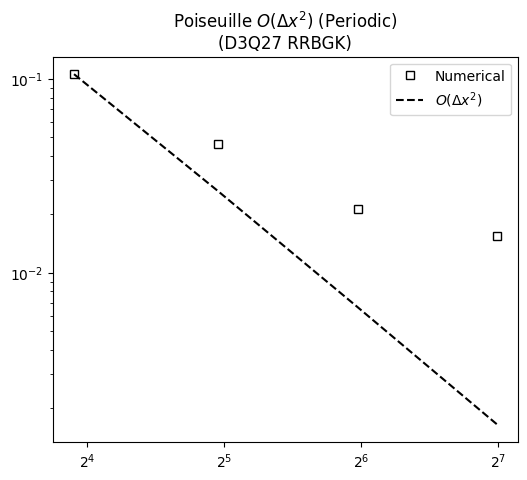

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

analytical_error_prof: list[float] = []
numerical_error_prof: list[float] = []
N_list: list[int] = []
analytical_func = get_poiseuille_pipe_analytical_func()

for sim_cfg in sim_cfgs_use:
    num_data = extracted_data[(sim_cfg.sim_id, sim_cfg.name)]
    num_avg_vel = get_poiseuille_pipe_numerical_avg_vel(num_data["data"])
    num_pos = num_data["pos"][:, 1].copy()
    R = num_pos.max() - num_pos.min()
    normalize_pos(num_pos)
    num_profile = num_data["data"] / num_avg_vel

    num_o2_error = common.get_o2_error(num_pos, num_profile, analytical_func)
    analyical_error = (
        num_o2_error if len(analytical_error_prof) == 0 else analytical_error_prof[-1] / 4
    )

    analytical_error_prof.append(analyical_error)
    numerical_error_prof.append(num_o2_error)
    N_list.append(R)

ax.plot(N_list, numerical_error_prof, "sk", fillstyle="none", label="Numerical")
ax.plot(N_list, analytical_error_prof, "--k", label=r"$O(\Delta x^2)$")

ax.set_yscale("log")
ax.set_xscale("log", base=2)
ax.set_title(
    r"Poiseuille $O(\Delta x^2)$ (Periodic)"
    + f"\n({sim_cfg.models.LBM.vel_set} {sim_cfg.models.LBM.coll_oper})"
)
ax.legend()
plt.show(fig)

The results show that the flow evolution equation from LBM converges to steady analytical solution.


## Version

In [7]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 09c9337ca174e12ce2cfa6eb39867054691a2742


## Configuration

In [8]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: periodicPoiseuillePipeN16
    run_simul: false
    save_path: ./tests/validation/results/03_poiseuille_pipe_flow/periodic
    n_steps: 2000
    report:
      frequency: 1000

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 0 }, macrs: [rho, u, f_IBM, S] }

    domain:
      domain_size:
        x: 24
        y: 24
        z: 24
      block_size: 8

      bodies:
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [8, 8, 8]
            translation: [-4, 4, 4]

    models:
      precision:
        default: single

      LBM:
        tau: 0.8
        F:
          x: 6.25E-05
          y: 0
          z: 0
        vel_set: D3Q27
        coll_oper: RRBGK

      engine:
        name: CUDA

      IBM:
        forces_accomodate_time: 1000
        body_cfgs:
          default: {}

      BC:
        periodic_dims: [true, false, false]
        BC_map:
          - pos: N
            BC: RegularizedHWBB
            wall_normal: N
            order: 1

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S
            order: 1

          - pos: F
            BC: RegularizedHWBB
            wall_normal: F
            order: 2

          - pos: B
            BC: RegularizedHWBB
            wall_normal: B
            order: 2

  - name: periodicPoiseuillePipeN32
    parent: periodicPoiseuillePipeN16

    n_steps: 8000

    domain:
      domain_size:
        x: 40
        y: 40
        z: 40
      block_size: 8
      bodies: !not-inherit
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [16, 16, 16]
            translation: [-4, 4, 4]

    models:
      LBM:
        F:
          x: 7.8125E-06
          y: 0
          z: 0

  - name: periodicPoiseuillePipeN64
    parent: periodicPoiseuillePipeN16

    n_steps: 32000

    domain:
      domain_size:
        x: 72
        y: 72
        z: 72
      block_size: 8
      bodies: !not-inherit
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [32, 32, 32]
            translation: [-4, 4, 4]
    models:
      LBM:
        F:
          x: 9.76563E-07
          y: 0
          z: 0

  - name: periodicPoiseuillePipeN128
    parent: periodicPoiseuillePipeN16

    n_steps: 128000

    domain:
      domain_size:
        x: 136
        y: 136
        z: 136
      block_size: 8
      bodies: !not-inherit
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [64, 64, 64]
            translation: [-4, 4, 4]
    models:
      LBM:
        F:
          x: 1.22070E-07
          y: 0
          z: 0

  - name: velocityNeumannPoiseuillePipeMultilevel
    save_path: ./tests/validation/results/03_poiseuille_pipe_flow/velocity_neumann_multilevel

    n_steps: 32000

    report:
      frequency: 1000

    data:
      divergence: { frequency: 1 }
      instantaneous:
        default: { interval: { frequency: 8000 }, macrs: [rho, u, f_IBM, S] }

    domain:
      domain_size:
        x: 104
        y: 48
        z: 48

      block_size: 8
      bodies_domain_limits:
        start: [4, 8, 8]
        end: [88, 40, 40]
        is_abs: true
      bodies:
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [8, 8, 8]
            translation: [4, 16, 16]
      refinement:
        static:
          default:
            bodies:
              - body_name: cylinder
                lvl: 1
                normal_offsets: [-2, 0, 2]

    models:
      precision:
        default: single

      LBM:
        tau: 0.51
        vel_set: D3Q27
        coll_oper: RRBGK

 